## Predicting Home Loans

Source: https://www.kaggle.com/ufffnick/loan-prediction-dream-housing-finance   
Data: https://www.kaggle.com/burak3ergun/loan-data-set

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes
import pickle

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

### import data

In [41]:
loans_df = pd.read_csv('../data/loan_data_set.csv')
loans_df.shape

(614, 13)

## Exploratory Data Analysis

In [42]:
# target variable: Approval of Mortgage Loan
print(loans_df[['Loan_Status']].value_counts())

Loan_Status
Y              422
N              192
dtype: int64


In [43]:
# continuous variables
print('\n',loans_df[['ApplicantIncome']].agg(['mean','median','min','max', 'std']))
print('\n',loans_df[['CoapplicantIncome']].agg(['mean','median','min','max', 'std']))
print('\n',loans_df[['LoanAmount']].agg(['mean','median','min','max', 'std']))


         ApplicantIncome
mean        5403.459283
median      3812.500000
min          150.000000
max        81000.000000
std         6109.041673

         CoapplicantIncome
mean          1621.245798
median        1188.500000
min              0.000000
max          41667.000000
std           2926.248369

         LoanAmount
mean    146.412162
median  128.000000
min       9.000000
max     700.000000
std      85.587325


In [44]:
# categorical variables
print('\n',loans_df[['Loan_Amount_Term']].value_counts().head())
print('\n',loans_df[['Property_Area']].value_counts())
print('\n',loans_df[['Gender']].value_counts())
print('\n',loans_df[['Education']].value_counts())
print('\n',loans_df[['Self_Employed']].value_counts())
print('\n', loans_df[['Credit_History']].value_counts())


 Loan_Amount_Term
360.0               512
180.0                44
480.0                15
300.0                13
84.0                  4
dtype: int64

 Property_Area
Semiurban        233
Urban            202
Rural            179
dtype: int64

 Gender
Male      489
Female    112
dtype: int64

 Education   
Graduate        480
Not Graduate    134
dtype: int64

 Self_Employed
No               500
Yes               82
dtype: int64

 Credit_History
1.0               475
0.0                89
dtype: int64


In [45]:
# combine the incomes (because sometimes coapplicant is missing)
loans_df['Combined_Income']=loans_df['ApplicantIncome'] + loans_df['CoapplicantIncome']

#### Visualize the relationships with the target

In [46]:
# plotly visualization of Loan Status
import plotly.graph_objects as go

# remove a few outliers & split
approved=loans_df[(loans_df['LoanAmount']<300) & (loans_df['Combined_Income']<25000) & (loans_df['Loan_Status']=='Y')]
denied=loans_df[(loans_df['LoanAmount']<300) & (loans_df['Combined_Income']<25000) & (loans_df['Loan_Status']=='N')]

trace0=go.Scatter3d(
    x=approved['LoanAmount'],
    y=approved['Combined_Income'],
    z=approved['Loan_Amount_Term'],
    name='approved',
    mode='markers',
    text = list(zip(
            ["Credit: {}".format(x) for x in loans_df['Credit_History']],
            ["Education: {}".format(x) for x in loans_df['Education']],
            ["Property Area: {}".format(x) for x in loans_df['Property_Area']],
            ["Gender: {}".format(x) for x in loans_df['Gender']],
            ["Education: {}".format(x) for x in loans_df['Education']],
            ["Self-Employed: {}".format(x) for x in loans_df['Self_Employed']]
            )) ,
    hoverinfo='text',
    marker=dict(size=5, color='blue', opacity=0.4))

trace1=go.Scatter3d(
    x=denied['LoanAmount'],
    y=denied['Combined_Income'],
    z=denied['Loan_Amount_Term'],
    name='denied',
    mode='markers',
    text = list(zip(
            ["Credit: {}".format(x) for x in loans_df['Credit_History']],
            ["Education: {}".format(x) for x in loans_df['Education']],
            ["Property Area: {}".format(x) for x in loans_df['Property_Area']],
            ["Gender: {}".format(x) for x in loans_df['Gender']],
            ["Education: {}".format(x) for x in loans_df['Education']],
            ["Self-Employed: {}".format(x) for x in loans_df['Self_Employed']]
            )) ,
    hoverinfo='text',
    marker=dict(size=5, color='red', opacity=0.4))

layout = go.Layout(title="Loan Status",
                    showlegend=True,
                        scene = dict(
                        xaxis=dict(title='Loan Amount'),
                        yaxis=dict(title='Combined Income'),
                        zaxis=dict(title='Term')
                ))
fig=go.Figure([trace0, trace1], layout)
fig

In [47]:
# save the figure for later use
fig.write_json('../model_components/cube-figure.json')

### Data Cleaning
- drop all NAs
- in a future iteration, we might improve performance by imputing rather than dropping

In [48]:
# check for missing data
loans_df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
Combined_Income       0
dtype: int64

In [49]:
# remove missing data & reset the index
loans_df.dropna(inplace=True)
loans_df.reset_index(drop=True, inplace=True)

## Categorical variables
- each column translated to binary value
- multi variables columns slpitted with dummy columns
- drop the duplications in the data

In [50]:
loans_df['Property_Area'].value_counts()

Semiurban    191
Urban        150
Rural        139
Name: Property_Area, dtype: int64

In [51]:
# preprocess the dataset
def categorize(df):
    df['Gender'].replace({'Male': 1, 'Female': 0}, inplace = True)
    df['Education'].replace({'Graduate': 1, 'Not Graduate': 0}, inplace = True)
    df['Loan_Status'].replace({'Y': 1, 'N':0}, inplace=True)
    df['Self_Employed'].replace({'Yes': 1, 'No': 0}, inplace = True)
    df['LoanAmount'] = df['LoanAmount']*1000
    return df

In [52]:
# apply the changes
print(loans_df.shape)
loans_df = categorize(loans_df)
print(loans_df.shape)
loans_df.head(2).T

(480, 14)
(480, 14)


,0,1
Loan_ID,LP001003,LP001005
Gender,1,1
Married,Yes,Yes
Dependents,1,0
Education,1,1
Self_Employed,0,1
ApplicantIncome,4583,3000
CoapplicantIncome,1508.0,0.0
LoanAmount,128000.0,66000.0
Loan_Amount_Term,360.0,360.0


### Adding new features:
- one hot encoding
- naive estimation of monthly loan return (LoanAmount/Loan_Amount_Term) 
- total income (ApplicantIncome + CoaplicantIncome) 
- both standardized and with ln() to get the distribution as close as possible to a normal distribution

In [53]:
# onehot encoding of categorical variables

encoder1=OneHotEncoder()
ohe=pd.DataFrame(encoder1.fit_transform(loans_df[['Property_Area']]).toarray())
col_list = ['Property_Area_{}'.format(item) for item in loans_df['Property_Area'].value_counts().index]
ohe.columns=col_list
loans_df = pd.concat([loans_df, ohe],axis=1)

In [54]:
# standardization

ss_scaler1 = StandardScaler()
ss_scaler2 = StandardScaler()
ss_scaler3 = StandardScaler()


ln_monthly_return_raw  = np.log(loans_df['LoanAmount']/loans_df['Loan_Amount_Term']).values
loans_df['ln_monthly_return'] = ss_scaler1.fit_transform(np.array(ln_monthly_return_raw).reshape(-1, 1))

ln_total_income_raw = np.log(loans_df['ApplicantIncome'] + loans_df['CoapplicantIncome'])
loans_df['ln_total_income'] = ss_scaler2.fit_transform(np.array(ln_total_income_raw).reshape(-1, 1)) 

ln_LoanAmount_raw = np.log(1000*loans_df['LoanAmount'])
loans_df['ln_LoanAmount'] = ss_scaler3.fit_transform(np.array(ln_LoanAmount_raw).reshape(-1, 1)) 

In [55]:
# drop additional variables that are reformatted or don't add much to the analysis.
dropit=['Loan_ID', 'Married', 'Dependents', 'Property_Area', 'Property_Area_Rural', 'LoanAmount',
        'Loan_Amount_Term','ApplicantIncome','CoapplicantIncome']
loans_df.drop(columns=dropit, 
           inplace=True)

In [56]:
loans_df.head()

,Gender,Education,Self_Employed,Credit_History,Loan_Status,Combined_Income,Property_Area_Semiurban,Property_Area_Urban,ln_monthly_return,ln_total_income,ln_LoanAmount
0,1,1,0,1.0,0,6091.0,1.0,0.0,-0.140781,0.082938,0.007246
1,1,1,1,1.0,1,3000.0,0.0,0.0,-1.317733,-1.237395,-1.292046
2,1,0,0,1.0,1,4941.0,0.0,0.0,-0.255457,-0.307167,-0.119351
3,1,1,0,1.0,1,6000.0,0.0,0.0,0.031095,0.054874,0.196987
4,1,1,1,1.0,1,9613.0,0.0,0.0,1.165604,0.933649,1.449424


## Model evaluation 

In [57]:
def mod_eval(df,predictions, predprob, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(df['Loan_Status'][y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    
    print(classification_report(df['Loan_Status'][y_test.index], predictions))
 
    fpr, tpr, _ = roc_curve(df['Loan_Status'][y_test.index], predprob[:,1])
    roc_auc = auc(fpr,tpr)

    precision, recall, thresholds = precision_recall_curve(y_test, predprob[:,1])
    best_index = np.argmin(np.abs(precision-recall)) # set the best index to be the minimum delta between precision and recall


In [58]:
# train-test split
X=loans_df.drop(columns=['Loan_Status', 'Combined_Income'])
y=loans_df['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                     test_size=.3,
                                                     stratify=loans_df['Loan_Status'])

## RandomForest

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        44
           1       0.80      0.89      0.84       100

    accuracy                           0.77       144
   macro avg       0.73      0.70      0.71       144
weighted avg       0.76      0.77      0.76       144



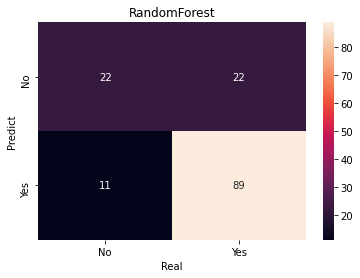

In [59]:
rf = RandomForestClassifier(random_state=42, 
                               n_jobs=4, 
                               n_estimators=50, 
                               max_depth=11,
                               max_features=6)


rf.fit(X_train, y_train)
mod_eval(loans_df, rf.predict(X_test), rf.predict_proba(X_test), y_test, 'RandomForest')


## LogisticRegression

              precision    recall  f1-score   support

           0       0.89      0.36      0.52        44
           1       0.78      0.98      0.87       100

    accuracy                           0.79       144
   macro avg       0.83      0.67      0.69       144
weighted avg       0.81      0.79      0.76       144



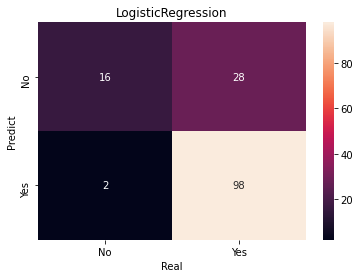

In [60]:
lr = LogisticRegression(C=0.1, 
                       penalty='l1',
                       solver='liblinear',
                       max_iter=1000)
lr.fit(X_train, y_train)
t = 0.71
predprob = lr.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
mod_eval(loans_df, pred_y, lr.predict_proba(X_test), y_test, 'LogisticRegression') 

## NaiveBayes

              precision    recall  f1-score   support

           0       0.62      0.52      0.57        44
           1       0.80      0.86      0.83       100

    accuracy                           0.76       144
   macro avg       0.71      0.69      0.70       144
weighted avg       0.75      0.76      0.75       144



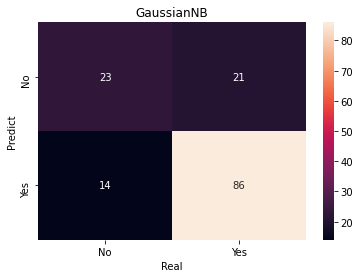

In [61]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)
t = 0.75
predprob = gnb.predict_proba(X_test)
pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
mod_eval(loans_df,pred_y, gnb.predict_proba(X_test), y_test, 'GaussianNB')

## SVC

t=0.75
              precision    recall  f1-score   support

           0       0.89      0.36      0.52        44
           1       0.78      0.98      0.87       100

    accuracy                           0.79       144
   macro avg       0.83      0.67      0.69       144
weighted avg       0.81      0.79      0.76       144



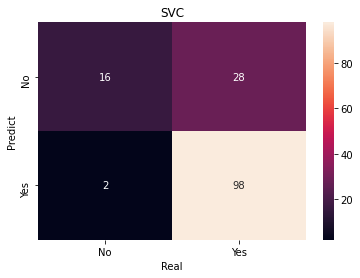

In [62]:
svc = SVC(kernel='linear',
         C=1, 
         gamma='auto',
         class_weight='balanced',
         probability=True)
svc.fit(X_train, y_train)
t=0.75
print('t={}'.format(t))
predprob = svc.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = svc.predict(X_test)

mod_eval(loans_df,pred_y, svc.predict_proba(X_test), y_test, 'SVC')
plt.show()

## Adaboost

In [63]:
from sklearn.ensemble import AdaBoostClassifier
boosting = AdaBoostClassifier(n_estimators=100, random_state=0)
boosting.fit(X_train, y_train).score(X_test, y_test)

0.7430555555555556

## Compare Models
- The RandomForest classifier has the best results

In [64]:
# compare final models: accuracy
import sklearn
accuracy_vals=[]
for val in [rf.predict(X_test),
lr.predict(X_test),
gnb.predict(X_test),
svc.predict(X_test)]:
    accuracy_vals.append(sklearn.metrics.accuracy_score(val, y_test.values))
accuracy_vals

[0.7708333333333334,
 0.7916666666666666,
 0.7708333333333334,
 0.7916666666666666]

In [65]:
# compare final models: ROCAUC
roc_vals=[]
for val in [rf.predict(X_test),
            lr.predict(X_test),
            gnb.predict(X_test),
            svc.predict(X_test)]:
    roc_vals.append(sklearn.metrics.roc_auc_score(val, y_test.values))
roc_vals

[0.7342342342342343,
 0.8333333333333333,
 0.7579949694574201,
 0.8333333333333333]

In [66]:
# display final values
models = ['random forest', 'logistic regression', 'naive bayes', 'support vector', 'dummy']
evaldf = pd.DataFrame(list(zip(models, accuracy_vals, roc_vals)))
evaldf.columns=['model', 'accuracy', 'rocauc']
evaldf=evaldf.set_index('model', drop=True)
evaldf

,accuracy,rocauc
model,,
random forest,0.770833,0.734234
logistic regression,0.791667,0.833333
naive bayes,0.770833,0.757995
support vector,0.791667,0.833333


In [67]:
# display results with plotly
trace0 = go.Bar(x= evaldf.index,
                y= evaldf['accuracy'].values,
                name='accuracy',
                marker=dict(color='rgb(100,200,300)'))
trace1 = go.Bar(x= evaldf.index,
                y= evaldf['rocauc'].values,
                name='roc-auc',
                marker=dict(color='rgb(300,200,100)'))
# now the layout
layout=go.Layout(title='Model Comparison',
                   xaxis= dict(title='Model'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0, trace1], layout=layout)
fig

## Take a look at the final results

In [68]:
# Random Forest feature importance
fi_df = pd.DataFrame({'fi': rf.feature_importances_},index=X_train.columns).sort_values(by='fi', ascending=False)
fi_df

,fi
Credit_History,0.330257
ln_total_income,0.227359
ln_monthly_return,0.180044
ln_LoanAmount,0.167892
Gender,0.025653
Property_Area_Urban,0.019209
Property_Area_Semiurban,0.018008
Self_Employed,0.015967
Education,0.015612


In [69]:
# display results with plotly
trace0 = go.Bar(x= fi_df.index,
                y= fi_df['fi'].values,
                marker=dict(color='rgb(100,200,300)'))

# now the layout
layout=go.Layout(title='Feature Importance',
                   xaxis= dict(title='Feature'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0], layout=layout)
fig

In [70]:
# what are the key variables like?
X_test[['Credit_History', 'ln_total_income', 'ln_monthly_return', 'ln_LoanAmount']].sample(3).T

,65,267,474
Credit_History,1.000000,1.000000,1.000000
ln_total_income,-1.083012,-0.301140,-0.218381
ln_monthly_return,0.331801,0.255716,-0.442668
ln_LoanAmount,0.528950,0.444956,-0.326022


## Pickle the model and its preprocessing steps

In [71]:
# save the dataframes for visualization
approved.to_csv('../model_components/approved_loans.csv', index=False)
denied.to_csv('../model_components/denied_loans.csv', index=False)

In [34]:
# pickle your random forest model
filename = open('../model_components/loan_approval_rf_model.pkl', 'wb')
pickle.dump(rf, filename)
filename.close()

In [35]:
# encoder1
filename = open('../model_components/loan_approval_onehot_encoder.pkl', 'wb')
pickle.dump(encoder1, filename)
filename.close()

In [36]:
# ss_scaler1: monthly_return
filename = open('../model_components/loan_approval_ss_scaler1.pkl', 'wb')
pickle.dump(ss_scaler1, filename)
filename.close()

In [37]:
# ss_scaler2: ln_total_income
filename = open('../model_components/loan_approval_total_income.pkl', 'wb')
pickle.dump(ss_scaler2, filename)
filename.close()

In [38]:
# ss_scaler3: loan_amount
filename = open('../model_components/loan_approval_loan_amount.pkl', 'wb')
pickle.dump(ss_scaler3, filename)
filename.close()